# NBA Salary Analysis

In this notebook, we're going to extract NBA salary data from 2005 to 2021 season from ESPN website and analyse the dataset . 

We'll try to answer the following questions:

1. What is the salary trend from 2005-2021? 
2. Which position earns most money? 

In [ ]:
import sys
!{sys.executable} -m pip install requests_html
from bs4 import BeautifulSoup
import pandas as pd
from requests_html import HTMLSession
import re
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Get nba players salary from ESPN database

# Web page contains JS code, use requests_html to render JS code
session = HTMLSession()
initial_url = "http://www.espn.com/nba/salaries/_/page/1/seasontype/33"
page = session.get(initial_url)
soup = BeautifulSoup(page.content, "lxml")

# get all seasons contained in the web page
all_season_link = soup.find("form", class_="js-goto").find_all("option")[1:]

# initialize player salary table
Player_Salary_Table = {
    'Player Name': [],
    'Player Position':[],
    'Season': [],
    'Player team': [],
    'Player Salary': [],
    }

# get Player Name/Season/team/salary for each player in each result found
# salary_table is each entry of the content found
# salary_table = soup.find("div", id="my-players-table").find_all("tr", class_=re.compile("row$"))
def get_player_salary(salary_table):
    player_name = salary_table.find_all("td")[1].find("a").text
    player_position = salary_table.find_all("td")[1].text[-2:]
    player_team = salary_table.find_all("td")[2].find("a").text
    player_salary = salary_table.find_all("td")[3].text
    player_season = salary_table.parent.parent.parent.find("h4").text[:9]

# add result to the player salary table
    Player_Salary_Table['Player Name'].append(player_name)
    Player_Salary_Table['Player Position'].append(player_position)
    Player_Salary_Table["Season"].append(player_season)
    Player_Salary_Table["Player team"].append(player_team)
    Player_Salary_Table["Player Salary"].append(player_salary)

# export final table to .csv file
def export_table(table):
    player_table = pd.DataFrame(table, columns=["Player Name", "Player Position", "Season","Player team","Player Salary"])
    print(player_table)
    print("scrape done.")
    player_table.to_csv("NBA_player_salary.csv",
                 sep=',', encoding='utf-8', index=False)
    print("File saved to .csv file")

# scrape all pages for all player entries in each season
def scrape_player_data(url):
    # for each url, get html file and locate the player information in salary_table
    page = session.get(url)
    soup = BeautifulSoup(page.content, "lxml")
    salary_table = soup.find("div", id="my-players-table").find_all("tr", class_=re.compile("row$"))
    #print(url)
    # see if there is anomaly; if yes then skip this player
    for player in salary_table:
        try:
            get_player_salary(player)
        except Exception:
            continue

    # test if the page for each season is the last page.
    # If yes, go to next page url (recursive function)
    # IF no, return table and exit
    if soup.find("div", class_="jcarousel-next jcarousel-next-disabled") is None:
        next_page_url = "http:" + soup.find("div", class_="controls").find_all("a", rel="nofollow")[-1]["href"]
        #print(next_page_url)
        scrape_player_data(next_page_url)
    else:
        return Player_Salary_Table

# scrape web page for all seasons;
for year in all_season_link:
    initial_url = "http:" + year["value"]
    #print("season: " + year.text)
    scrape_player_data(initial_url)

export_table(Player_Salary_Table)
Player_Salary_Table.head()

In [3]:
# import salary data scraped from ESPN
NBA_player_salary = pd.read_csv("NBA_player_salary.csv")
NBA_player_salary.head()

# clean NBA_player_salary data
# get correct salary format
NBA_player_salary["Player Salary"] = NBA_player_salary["Player Salary"].replace('[\$,]', '', regex=True).astype(float)

# get player position formatted
NBA_player_salary["Player Position"].replace(" ","", regex = True, inplace = True)


# update Eddy Curry's position info & drop other unknown players
NBA_player_salary.loc[NBA_player_salary["Player Name"] == "Eddy Curry","Player Position"] = "PF"
NBA_player_salary = NBA_player_salary[NBA_player_salary["Player Position"].isnull() == False]
#

# get data only after 2005-2006
NBA_player_salary = NBA_player_salary[NBA_player_salary["Season"]>="2005-2006"]

NBA_player_salary

,Player Name,Player Position,Season,Player team,Player Salary
0,Stephen Curry,PG,2020-2021,Golden State Warriors,43006362.0
1,Russell Westbrook,PG,2020-2021,Washington Wizards,41358814.0
2,Chris Paul,PG,2020-2021,Phoenix Suns,41358814.0
3,James Harden,SG,2020-2021,Brooklyn Nets,41254920.0
4,John Wall,PG,2020-2021,Houston Rockets,41254920.0
...,...,...,...,...,...
7986,Martynas Andriuskevicius,C,2005-2006,Cleveland Cavaliers,398762.0
7987,Dijon Thompson,SF,2005-2006,Phoenix Suns,398762.0
7988,C.J. Miles,SG,2005-2006,Utah Jazz,398761.0
7989,Donell Taylor,PG,2005-2006,Washington Wizards,398672.0


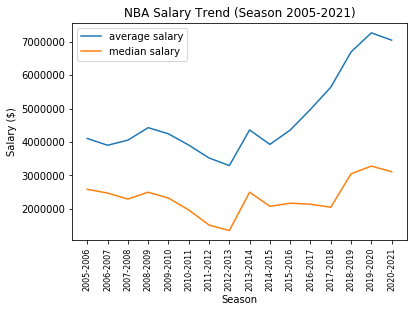

In [4]:
# get player average salary for each year & plot
avg_salary_trend = NBA_player_salary.groupby(by = "Season").mean().reset_index()

# get median salary for each year & plot
median_salary_trend = NBA_player_salary.groupby(by = "Season").median().reset_index()

# compare median & average
fig = plt.figure() 
fig_salary_compare = fig.add_subplot(111)
fig_salary_compare.plot(avg_salary_trend["Season"].to_numpy(),avg_salary_trend["Player Salary"].to_numpy(),label = "average salary")
fig_salary_compare.plot(median_salary_trend["Season"].to_numpy(),median_salary_trend["Player Salary"].to_numpy(),label = "median salary")
fig_salary_compare.tick_params(axis='x', rotation=90, labelsize=8)
fig_salary_compare.set(title = "NBA Salary Trend (Season 2005-2021)", ylabel = "Salary ($)", xlabel = "Season")
fig_salary_compare.legend(loc = "upper left")


### Question: What is the salary trend from 2005-2021? 

**Conclusion**: 
- Average salary
 1. NBA average salary varied from season 2005/06 to 2014/15, with a slight decreasing trend. 
 1. After season 2014/15, average salary almost doubled in 6 years' time


- Median salary
 1. Suprisingly, median salary is much lower than average salary (only half of average salary)
 1. Trend for median salary is similar to that of average salary. However, from Season 2014/15, the diffrenence became even larger

Further Question: 
**What causes the difference between average salary and median salary?**

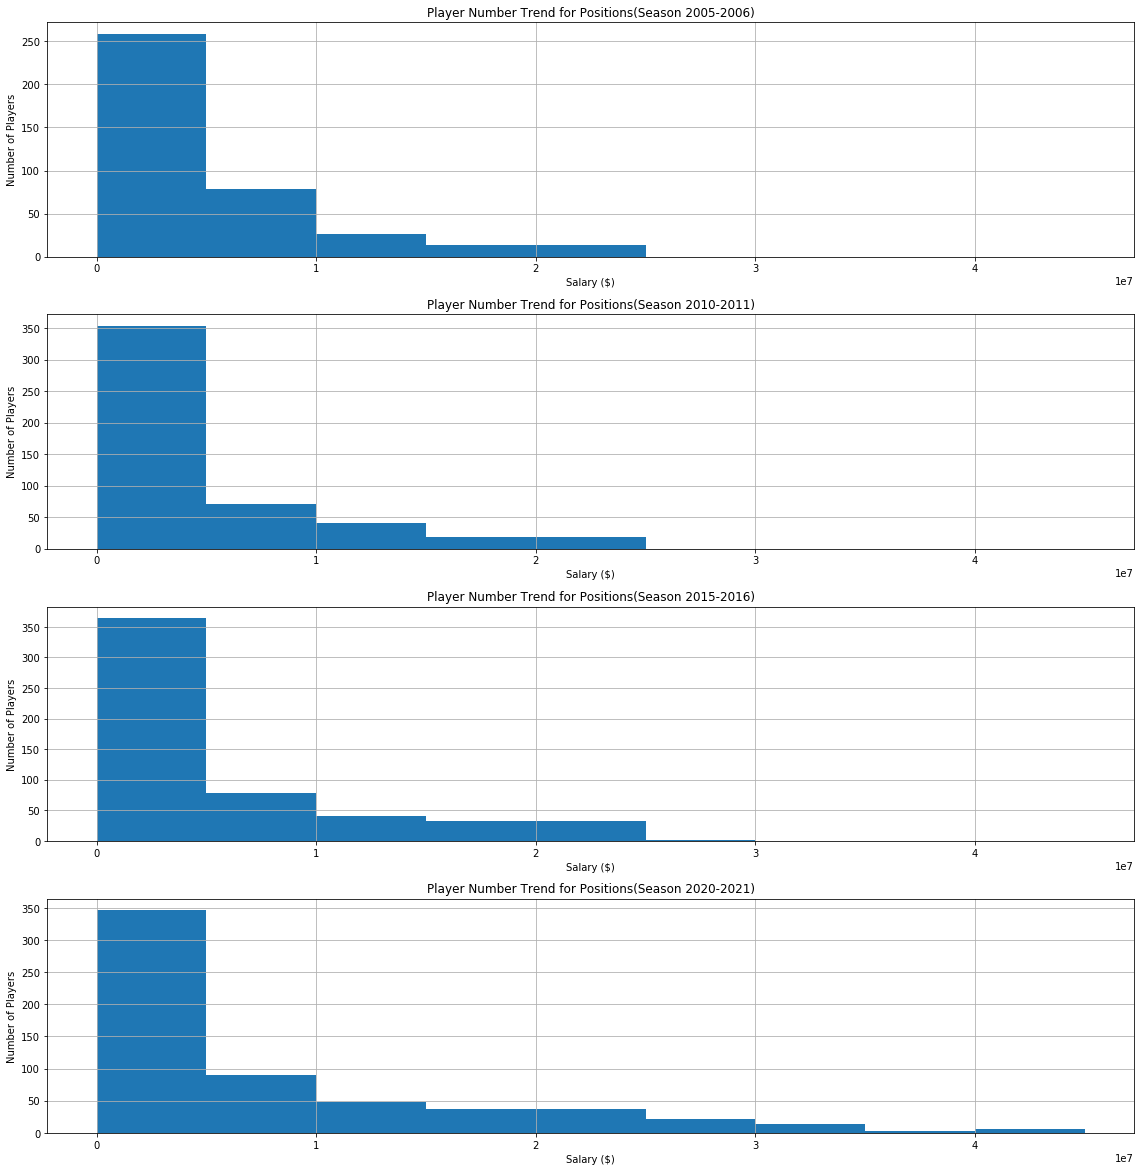

In [17]:
# get hist map for each salary range & plot

#salary hist map for 05-06/10-11/15-16/20-21 seasons
hist_season = season = NBA_player_salary["Season"].unique()[::-1][::5]
fig = plt.figure(figsize=(16,20))
bins = [0, 5000000, 10000000, 15000000, 25000000, 30000000, 35000000, 40000000, 45000000]

for i in range(0,len(hist_season)):
    salary_hist = fig.add_subplot(5,1,i+1)
    salary_hist.hist(NBA_player_salary[NBA_player_salary["Season"]==hist_season[i]]["Player Salary"], bins = bins)
    salary_hist.set(title = f'Player Number Trend for Positions(Season {hist_season[i]})', ylabel = "Number of Players", xlabel = "Salary ($)")
    salary_hist.grid()
    
fig.tight_layout()

### What causes the difference between average salary and median salary?

**Conclusion**: 

Most players in the league earn less than 1 million per year, which is far less than top players;

This causes the fact that median salary is much less than average salary

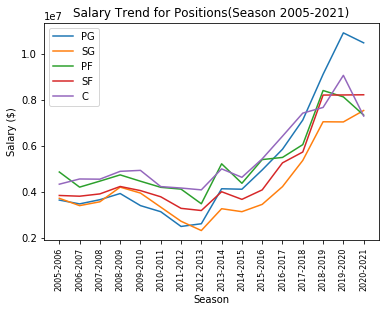

In [5]:
# get each position average salary for each year & plot
NBA_player_salary.groupby(["Player Position","Season"]).mean()
position = NBA_player_salary["Player Position"].unique()[0:5]

# plot salary trend for each position in a line chart
fig = plt.figure() 
fig_position_salary = fig.add_subplot(111)

for player_position in position:
    A = NBA_player_salary[NBA_player_salary["Player Position"] == player_position].groupby(by = "Season").mean().reset_index()
    Position_salary = A["Player Salary"].to_numpy()
    Season = A["Season"].to_numpy()
    fig_position_salary.plot(Season, Position_salary, label = player_position)
    fig_position_salary.tick_params(axis='x', rotation=90, labelsize=8)
    fig_position_salary.set(title = "Salary Trend for Positions(Season 2005-2021)", ylabel = "Salary ($)", xlabel = "Season")
    fig_position_salary.legend(loc = "upper left")


### Which position earns most money? 

**Conclusion**:

Before Season 2016/17, players in PF (power forward) and Center earns most money. 

After Season 2016/17, players in PG (point guard) has highest average salary. 

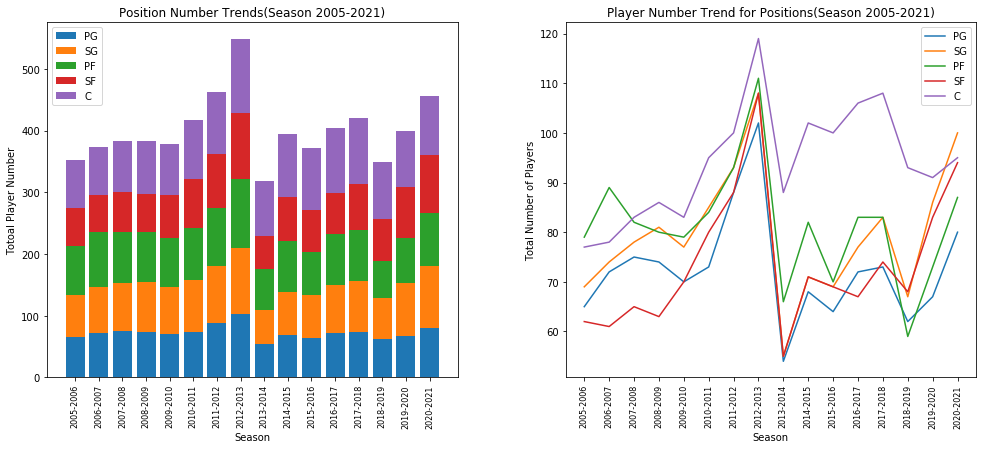

In [8]:
# get number of each position in each season
position_stats = {
                    "Player Position" : [],
                    "Total Players" : [],
                    "Season" : []
                  }

position = NBA_player_salary["Player Position"].unique()[0:5]
seasons = NBA_player_salary["Season"].unique()[::-1]
for season in seasons:
    this_season_stats = NBA_player_salary[NBA_player_salary["Season"] == season]
    for player_position in position:  
        this_season = season
        total_players = len(this_season_stats[this_season_stats["Player Position"] == player_position])
        position_stats["Player Position"].append(player_position)
        position_stats["Season"].append(this_season)
        position_stats["Total Players"].append(total_players)


Position_Stats = pd.DataFrame(position_stats, columns=["Player Position", "Total Players", "Season"])

# plot player numbers in different position
fig = plt.figure(figsize=(16,8)) 
position_occupancy = fig.add_subplot(121)
fig.tight_layout(pad=10)
PG_num = Position_Stats[Position_Stats["Player Position"] == "PG"]["Total Players"].to_numpy()
SG_num = Position_Stats[Position_Stats["Player Position"] == "SG"]["Total Players"].to_numpy()
PF_num = Position_Stats[Position_Stats["Player Position"] == "PF"]["Total Players"].to_numpy()
SF_num = Position_Stats[Position_Stats["Player Position"] == "SF"]["Total Players"].to_numpy()
C_num = Position_Stats[Position_Stats["Player Position"] == "C"]["Total Players"].to_numpy()
position_occupancy.bar(seasons, PG_num, label='PG')
position_occupancy.bar(seasons, SG_num, label='SG', bottom = PG_num)
position_occupancy.bar(seasons, PF_num, label='PF', bottom = SG_num+PG_num)
position_occupancy.bar(seasons, SF_num, label='SF', bottom = SG_num+PG_num+PF_num)
position_occupancy.bar(seasons, C_num, label='C', bottom = SG_num+PG_num+PF_num+SF_num)
position_occupancy.tick_params(axis='x', rotation=90, labelsize=8)
position_occupancy.set(title = "Position Number Trends(Season 2005-2021)", ylabel = "Totoal Player Number", xlabel = "Season")
position_occupancy.legend(loc = "best")

# plot each position number trend
position_trend = fig.add_subplot(122)
for player_position in position:
    position_num = Position_Stats[Position_Stats["Player Position"] == player_position]["Total Players"].to_numpy()
    position_trend.plot(Season, position_num, label = player_position)
    position_trend.tick_params(axis='x', rotation=90, labelsize=8)
    position_trend.set(title = "Player Number Trend for Positions(Season 2005-2021)", ylabel = "Total Number of Players", xlabel = "Season")
    position_trend.legend(loc = "best")


In [18]:
# calculate total salary for each team in each season

# get all NBA team name
Teams = NBA_player_salary["Player team"].unique()

# get all season
Seasons = NBA_player_salary["Season"].unique()

Team_Salary = {
    'Team': [],
    'Season':[],
    'Team Salary(Total)': [],
}

# Get total salary for each team in each season
for season in Seasons:
    for team in Teams:
        total_salary = NBA_player_salary[(NBA_player_salary["Player team"] == team) & (NBA_player_salary["Season"] == season)]["Player Salary"].sum()
        Team_Salary["Team"].append(team)
        Team_Salary["Season"].append(season)
        Team_Salary["Team Salary(Total)"].append(total_salary)

Team_Salary = pd.DataFrame(Team_Salary, columns = ['Team', 'Season','Team Salary(Total)'])
Team_Salary

,Team,Season,Team Salary(Total)
0,Golden State Warriors,2020-2021,171599787.0
1,Washington Wizards,2020-2021,154312088.0
2,Phoenix Suns,2020-2021,134846782.0
3,Brooklyn Nets,2020-2021,193411959.0
4,Houston Rockets,2020-2021,123051698.0
...,...,...,...
475,Sacramento Kings,2005-2006,63229665.0
476,Indiana Pacers,2005-2006,73126708.0
477,Detroit Pistons,2005-2006,60548979.0
478,New York Knicks,2005-2006,93260601.0


In [307]:
# import NBA team rank data
team_rank = pd.read_csv("~/Desktop/Python/Python_DA/NBA_salary_analysis/NBA_team_rank.csv")

# clean NBA team rank data
# test if 2 dataset has same team name (sometimes team name has different format)
a = sorted(team_rank["Team"].unique()) 
b = sorted(Team_Salary["Team"].unique())
c = pd.DataFrame(a, b).reset_index().rename(columns = {'index':'Name in team_rank', 0:'Name in Team_Salary'})
c[c["Name in team_rank"] != c["Name in Team_Salary"]]

# transfer team names in team_rank table to match names in Team_salary table
for i in range(0,len(a)):
    if a[i] != b[i]:
        team_rank.replace({'Team': {a[i]: b[i]}},inplace = True)
    else:
        pass

# test if team name matched in 2 tables
if sorted(team_rank["Team"].unique()) == sorted(Team_Salary["Team"].unique()):
    print("Team name matched")
else: print("Team name not match")

#set season format in team_rank to match team_salary
team_rank["Season"].replace('-','-20', regex=True, inplace = True)
team_rank

Team name matched


,Season,Season Status,Team,Team Rank
0,2000-2001,Regular Season,Chicago Bulls,15
1,2000-2001,Regular Season,LA Clippers,12
2,2000-2001,Playoffs,Orlando Magic,7
3,2000-2001,Playoffs,Toronto Raptors,5
4,2000-2001,Regular Season,Atlanta Hawks,13
...,...,...,...,...
591,2019-2020,Conference Champion,Miami Heat,5
592,2019-2020,Regular Season,Cleveland Cavaliers,15
593,2019-2020,Playoffs,Oklahoma City Thunder,5
594,2019-2020,Playoffs,Portland Trail Blazers,8


In [298]:
#combine team rank with team salary table
table1 = Team_Salary.assign(id = Team_Salary["Season"] + Team_Salary["Team"])
table2 = team_rank.assign(id = team_rank["Season"] + team_rank["Team"])

# test
#sorted(table1["id"].unique()) == sorted(table2["id"].unique())
team_status = pd.merge(table1, table2, how='inner', on='id')
team_status.drop(["Team_y","Season_y", "id"], axis = 1, inplace = True)
team_status.rename(columns = {"Team_x":"Team","Season_x":"Season"}, inplace = True)
team_status

,Team,Season,Team Salary(Total),Season Status,Team Rank
0,Golden State Warriors,2019-2020,133016952.0,Regular Season,15
1,Washington Wizards,2019-2020,108900157.0,Regular Season,9
2,Phoenix Suns,2019-2020,109282990.0,Regular Season,10
3,Brooklyn Nets,2019-2020,132701299.0,Playoffs,7
4,Houston Rockets,2019-2020,189561869.0,Playoffs,4
...,...,...,...,...,...
445,Sacramento Kings,2005-2006,63229665.0,Playoffs,8
446,Indiana Pacers,2005-2006,73126708.0,Playoffs,6
447,Detroit Pistons,2005-2006,60548979.0,Playoffs,1
448,New York Knicks,2005-2006,93260601.0,Regular Season,15
